# Several analysers of the classification model on many images of the on LeafSnap30 data subset using iNNvestigateon 

### Settings

In [1]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

Using TensorFlow backend.


### Load the data and split into train, test and validation

In [2]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Split the data into train, test and validation

In [3]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (4295, 64, 64, 3)
Labels size - train set:  (4295, 30)
Image size - valid. set:  (1227, 64, 64, 3)
Labels size - valid. set:  (1227, 30)
Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522


In [4]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

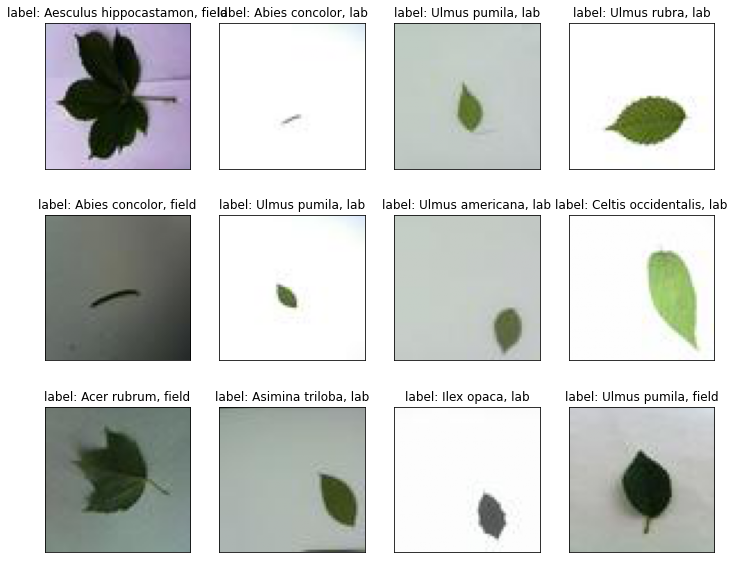

In [5]:
# plot random train images
d.plot_12images(images = images_train, labels = labels_train, sources = sources_train, figsize=(12,10))

### Data formatting

In [6]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (4295, 64, 64, 3)
Size of validation data:  (1227, 64, 64, 3)
Size of testing data:  (614, 64, 64, 3)


## Model

In [7]:
# path of the Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')

# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 12)        912       
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 12)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 24)        7224      
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 24)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 24)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 4056)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 200)             

Evaluate on test images

In [8]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

Test loss: 0.8515864030157704
Test accuracy: 74.9185667946595 %


### Predicted classes

In [11]:
pred = model.predict_classes(images_test)
#print(pred)
predictions= pd.DataFrame({'prediction_numeric': pred, 'label_numeric': labels_numeric_test, 'label': labels_test, 'source': sources_test, 'filename':filenames_test, 'path':path_test})
#order columns
predictions = predictions[['prediction_numeric', 'label_numeric', 'label', 'source', 'filename', 'path']]
predictions.head()

,prediction_numeric,label_numeric,label,source,filename,path
5522,27,27,Abies concolor,lab,ny1178-10-1.jpg,dataset/images/lab/Auto_cropped/abies_concolor...
5523,17,22,Acer rubrum,lab,pi2773-04-4.jpg,dataset/images/lab/Auto_cropped/acer_rubrum/pi...
5524,28,17,Ulmus americana,lab,pi0020-02-2.jpg,dataset/images/lab/Auto_cropped/ulmus_american...
5525,4,5,Celtis occidentalis,field,1248106179_0005.jpg,dataset/images/field/celtis_occidentalis/12481...
5526,7,7,Magnolia acuminata,lab,wb1221-02-1.jpg,dataset/images/lab/Auto_cropped/magnolia_acumi...


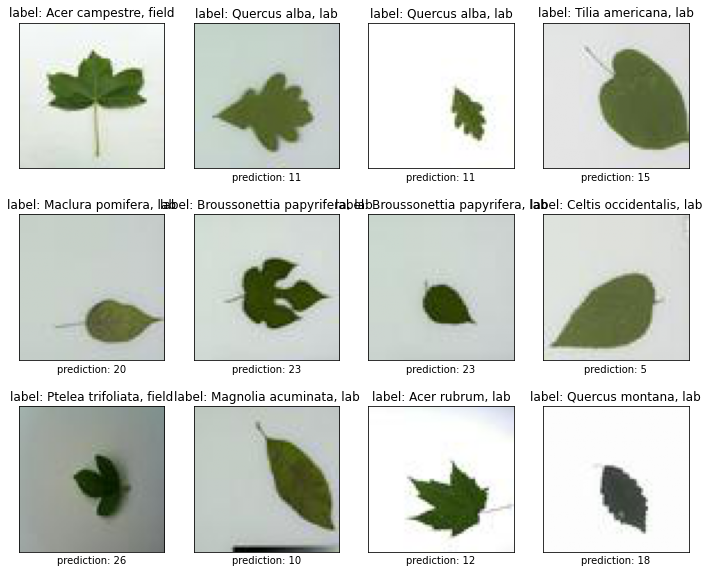

In [14]:
# display 12 random images and display their predictions
predictions_numeric_test = predictions['prediction_numeric']
d.plot_12images(images = images_test, labels = labels_test, predictions = predictions_numeric_test, sources = sources_test, figsize=(12,10))

#TODO: add the names of the predicted species!